In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib


In [4]:
data = pd.read_csv("without_HardwareTroj.csv").drop("HT", axis=1)

In [5]:
data

,Impedance,Resistance,Reactance
0,56.85,-798.00,3.950000e-11
1,67.83,-850.18,3.600000e-11
2,59.84,-835.34,3.560000e-11
3,60.60,-805.52,3.590000e-11
4,59.28,-778.88,3.620000e-11
...,...,...,...
9996,196.93,174.59,1.860000e-08
9997,197.90,174.75,1.860000e-08
9998,201.87,174.87,1.860000e-08
9999,200.02,173.07,1.840000e-08


In [6]:
# Select the columns you want to predict
columns_to_predict = ['Impedance', 'Resistance', 'Reactance']


In [7]:
data

,Impedance,Resistance,Reactance
0,56.85,-798.00,3.950000e-11
1,67.83,-850.18,3.600000e-11
2,59.84,-835.34,3.560000e-11
3,60.60,-805.52,3.590000e-11
4,59.28,-778.88,3.620000e-11
...,...,...,...
9996,196.93,174.59,1.860000e-08
9997,197.90,174.75,1.860000e-08
9998,201.87,174.87,1.860000e-08
9999,200.02,173.07,1.840000e-08


In [8]:
# data[columns_to_predict] = scaler.inverse_transform(data[columns_to_predict])
# data

In [9]:
sequence_length = 5 

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length][columns_to_predict].values)
        y.append(data.iloc[i+sequence_length][columns_to_predict].values)
    return np.array(X), np.array(y)

X, y = create_sequences(data, sequence_length)

In [10]:
X.shape

(9996, 5, 3)

In [11]:
y.shape

(9996, 3)

In [12]:
# Define the split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8

# Calculate the split index
split_index = int(len(X) * split_ratio)

# Split the data into train and test sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [13]:
print(X_train.shape, X_test.shape)

(7996, 5, 3) (2000, 5, 3)


In [14]:
print(y_train.shape, y_test.shape)

(7996, 3) (2000, 3)


In [15]:
# Create the model
model = Sequential()

model.add(LSTM(128, input_shape=(sequence_length, len(columns_to_predict)), activation='relu', return_sequences=True))

model.add(LSTM(64, activation='relu'))  
model.add(Dropout(0.001))

model.add(Dense(len(columns_to_predict)))

# Compile the model with custom learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            67584     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 117187 (457.76 KB)
Trainable params: 117187 (457.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, verbose=1, callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3))


Epoch 1/60
200/200 [==============================] - 9s 21ms/step - loss: 4385.5186 - val_loss: 4837.5688
Epoch 2/60
200/200 [==============================] - 3s 15ms/step - loss: 669.6852 - val_loss: 201.3760
Epoch 3/60
200/200 [==============================] - 3s 14ms/step - loss: 109.0229 - val_loss: 148.2585
Epoch 4/60
200/200 [==============================] - 3s 15ms/step - loss: 51.6301 - val_loss: 106.1947
Epoch 5/60
200/200 [==============================] - 3s 16ms/step - loss: 31.3836 - val_loss: 82.3537
Epoch 6/60
200/200 [==============================] - 3s 15ms/step - loss: 32.3545 - val_loss: 94.8253
Epoch 7/60
200/200 [==============================] - 3s 15ms/step - loss: 27.9809 - val_loss: 57.5548
Epoch 8/60
200/200 [==============================] - 3s 17ms/step - loss: 19.0626 - val_loss: 60.2794
Epoch 9/60
200/200 [==============================] - 3s 17ms/step - loss: 21.1173 - val_loss: 75.7965
Epoch 10/60
200/200 [==============================] - 3s 16ms/s

Text(0.5, 1.0, 'Loss Curves')

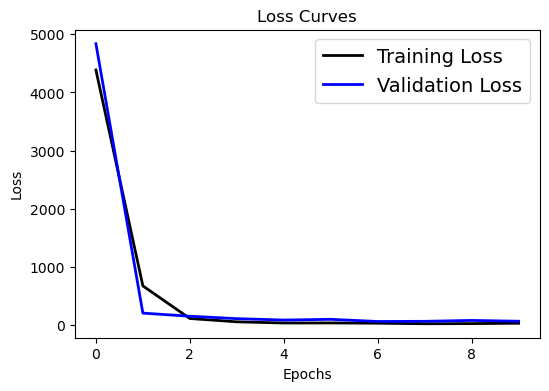

In [17]:
# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [18]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

63/63 [==============================] - 1s 8ms/step - loss: 13.3911
Test Loss: 13.391103744506836


In [19]:
predictions = model.predict(X_train)

250/250 [==============================] - 2s 7ms/step


In [20]:
predictions.shape

(7996, 3)

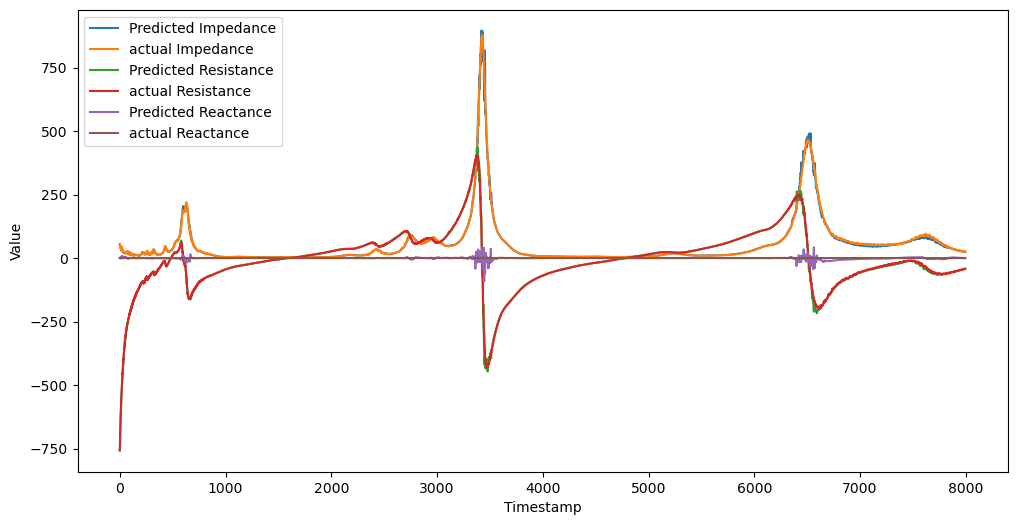

In [21]:
#plotting the train vs predicted 


plt.figure(figsize=(12, 6))
for i, column in enumerate(columns_to_predict):
    plt.plot(predictions[:, i], label=f'Predicted {column}')
    plt.plot(y_train[:, i], label=f'actual {column}')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [22]:
predictions = model.predict(X_test)

63/63 [==============================] - 0s 6ms/step


In [23]:
predictions.shape

(2000, 3)

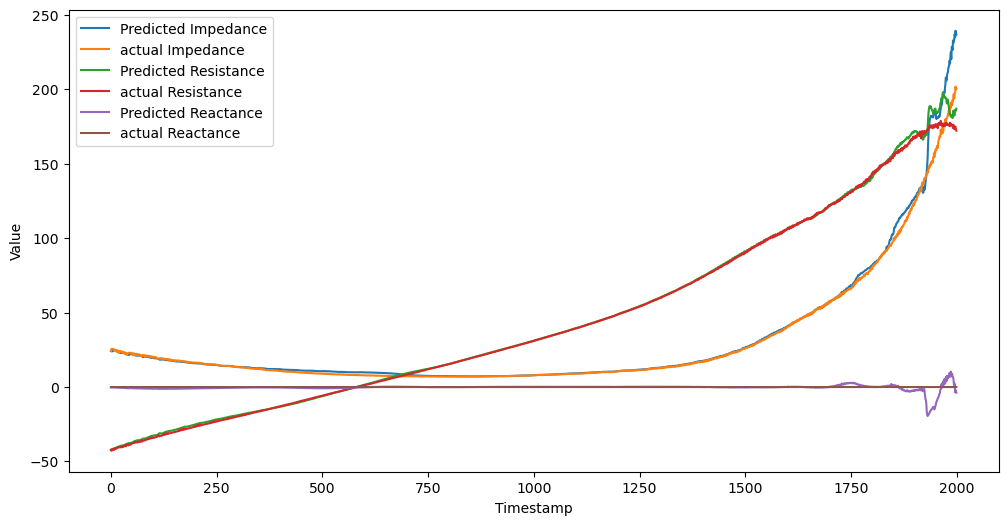

In [24]:
# plotting the test vs predicted

plt.figure(figsize=(12, 6))
for i, column in enumerate(columns_to_predict):
    plt.plot(predictions[:, i], label=f'Predicted {column}')
    plt.plot(y_test[:, i], label=f'actual {column}')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

comparing the predicted values vs actual values for our test dataset.

In [25]:

pd.DataFrame(model.predict(X_test))

63/63 [==============================] - 0s 6ms/step


,0,1,2
0,24.315386,-42.118130,-0.257959
1,24.214350,-41.996426,-0.296046
2,24.108288,-41.697659,-0.365319
3,23.934984,-41.620255,-0.285121
4,24.090273,-41.521404,-0.252461
...,...,...,...
1995,237.031677,182.950974,2.203118
1996,235.118500,186.295944,-3.465829
1997,239.413528,185.439224,-1.915397
1998,237.378250,185.953384,-3.857423


In [26]:
pd.DataFrame(y_test)

,0,1,2
0,24.16,-42.25,3.150000e-12
1,25.49,-42.79,3.110000e-12
2,25.37,-42.72,3.110000e-12
3,25.63,-42.00,3.160000e-12
4,25.63,-41.93,3.170000e-12
...,...,...,...
1995,196.93,174.59,1.860000e-08
1996,197.90,174.75,1.860000e-08
1997,201.87,174.87,1.860000e-08
1998,200.02,173.07,1.840000e-08


A demo on how to make predictions on the data the model has never seen before. we are giving the last 6 rows of data to our model. and it's gonna predict us the next 
* the model will need the previous 6 reading to be able to predict the next values.



In [57]:

# assign your new dataset to new_data variable..
new_data = data[8000:8006]


# Create sequences for prediction
X_new = []


for i in range(len(new_data) - sequence_length):
    X_new.append(new_data[columns_to_predict].iloc[i:i+sequence_length].values)

X_new = np.array(X_new)

# Make predictions
predictions = model.predict(X_new)


pd.DataFrame(predictions)

1/1 [==============================] - 0s 41ms/step


,0,1,2
0,24.090269,-41.521408,-0.252459


In [58]:
pd.DataFrame((new_data))

,Impedance,Resistance,Reactance
8000,24.38,-42.35,3.140000e-12
8001,24.16,-42.25,3.150000e-12
8002,25.49,-42.79,3.110000e-12
8003,25.37,-42.72,3.110000e-12
8004,25.63,-42.00,3.160000e-12
8005,25.63,-41.93,3.170000e-12


In [60]:
# Number of recursive predictions you want to make
num_predictions = 3

# Create a list to store the predictions
recursive_predictions = []

for _ in range(num_predictions):
    # Reshape the last sequence for prediction
    input_data = X_new[-1].reshape(1, sequence_length, len(columns_to_predict))
    
    # Make a prediction for the next time step
    prediction = model.predict(input_data)[0]
    
    # Append the prediction to the list
    recursive_predictions.append(prediction)
    
    # Update the input data for the next prediction
    X_new[-1] = np.vstack((X_new[-1][1:], prediction))

    

# Print the recursive predictions
print("Recursive Predictions:")
rec_preds = pd.DataFrame(recursive_predictions, columns= ['Impedance', 'Resistance', 'Reactance'])
rec_preds

1/1 [==============================] - 0s 45ms/step
Recursive Predictions:


,Impedance,Resistance,Reactance
0,24.229929,-41.294571,-0.403357
1,23.998060,-40.973663,-0.412223
2,23.631247,-40.699314,-0.509893


In [61]:

# Specify the file path where the model is saved
model_filename = 'random_forest_model.pkl'
loaded_rf = joblib.load(model_filename)

print(f"{model_filename} loaded in the notebook and ready for predictions")


random_forest_model.pkl loaded in the notebook and ready for predictions


In [62]:
# Now, you can use the loaded model for predictions
loaded_rf.predict(rec_preds)

array([0, 0, 0], dtype=int64)